# Importación de librerías 🐍

In [1]:
import os
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Librería SpaCy para preprocesamiento de texto
import spacy
!python -m spacy download es_core_news_sm

import emoji

# Vectorizaciones basadas en BoW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modelos "clásicos" de ML
from sklearn.naive_bayes import ComplementNB, \
    BernoulliNB  # BoW con pesado binario
from sklearn.svm import LinearSVC

# Obtención de embeddings contextuales
from transformers import AutoTokenizer, TFAutoModel

# Modelos de DL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D

# Métricas de rendimiento para evaluar los modelos
from sklearn.metrics import f1_score, \
    accuracy_score, \
    precision_score,\
    recall_score,\
    confusion_matrix,\
    ConfusionMatrixDisplay

# Guardar modelos ya entrenados
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 45.9 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


/opt/anaconda3/envs/practica_pln1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clasificación de ideologías de tuits 🐦

## Carga de datos 💾

In [2]:
"""
- Definimos la ruta en que se encuentran nuestros datos y cargamos los DFs necesarios

"""
data_path = "data"
data_generated_path = os.path.join(data_path, "generated")
resources_generated_path = os.path.join("resources", "generated")
models_path = os.path.join("models")

train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
dev_df = pd.read_csv(os.path.join(data_path, "development.csv"))

In [3]:
train_df.head()

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,37732,@user239,female,politician,right,moderate_right,"@user, propuestas de futuro 💪#no tocar las ref..."
1,38447,@user13,female,journalist,left,left,@user @user Podemos entrar en bucle hasta el i...
2,10758,@user8,female,politician,left,moderate_left,👉🏻Como gallega me produce profunda decepción v...
3,33860,@user262,male,politician,right,right,"Y ahora, tras este raro de amable discusión so..."
4,11677,@user341,female,politician,right,right,1-No se trata de defender o no la labor de @us...


In [4]:
dev_df.head()

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,14755,@user206,female,journalist,left,moderate_left,En unos minutos adelantaremos en @user imágene...
1,31904,@user137,female,politician,left,moderate_left,"Vacunar, vacunar y vacunar. Ese es el gran obj..."
2,45517,@user180,male,journalist,right,moderate_right,Me voy para @user. Hoy no hay programa pero es...
3,11015,@user290,male,politician,left,left,Vivimos en un país en el 12 mill y medio de pe...
4,25991,@user228,male,politician,right,moderate_right,En casa de la VP Rivera no les gusta q se habl...


In [5]:
"""
- Extraemos las etiquetas (labels) para la clasificación y los tuits
"""
labels = {
    "moderate_left": 0,
    "left": 1,
    "moderate_right": 2,
    "right": 3
}

print("- Etiquetas:")
print(f"    - Existen {len(labels)} clases:")
for l, i in labels.items():
    print(f"        - {l} -> {i}")

corpus_train = train_df["tweet"].tolist()
y_train = np.array([labels[l] for l in train_df["ideology_multiclass"]]).reshape(len(corpus_train), 1)
corpus_dev = dev_df["tweet"].tolist()
y_dev = np.array([labels[l] for l in dev_df["ideology_multiclass"]]).reshape(len(corpus_dev), 1)

print("- Conjuntos de datos:")
print("    - Entrenamiento:")
print(f"        - {y_train.shape[0]} ejemplos.")
print("    - Desarrollo (Test):")
print(f"        - {y_dev.shape[0]} ejemplos.")

- Etiquetas:
    - Existen 4 clases:
        - moderate_left -> 0
        - left -> 1
        - moderate_right -> 2
        - right -> 3
- Conjuntos de datos:
    - Entrenamiento:
        - 28065 ejemplos.
    - Desarrollo (Test):
        - 4678 ejemplos.


## Visualización y preprocesamiento de los datos 🔍

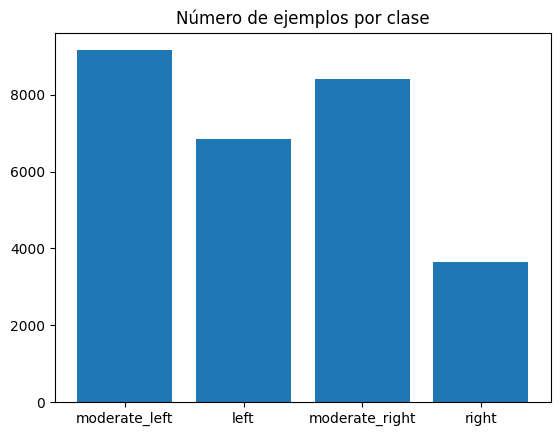

In [6]:
"""
- Número de ejemplos de cada clase
"""
filename = "train_classes_hist.png"
save_flag = True

classes, samples_per_class = np.unique(y_train, return_counts=True)
classes = [list(labels.keys())[c] for c in classes]

plt.figure()
plt.title("Número de ejemplos por clase")
plt.bar(classes, samples_per_class)
if save_flag:
    plt.savefig(os.path.join(resources_generated_path, filename))
plt.show()

- Como los textos proporcionados se encuentran escritos en español, utilizamos el modelo "es_core_news_sm" de SpaCy (https://spacy.io/models/es).

In [7]:
spacy_model = "es_core_news_sm"
nlp = spacy.load(spacy_model)

def preprocess_sent(model,
                    text,
                    lowercase=True,
                    remove_urls=True,
                    remove_punct=True,
                    remove_numbers=False,
                    remove_stopwords=True,
                    lemmatize=False,
                    remove_hashtags=True,
                    remove_mentions=True,
                    remove_emojis=False,
                    min_token_length=3):
    if not text:
        return ""
    
    t = text
    
    if lowercase:
        t = text.lower()
    
    if remove_urls:
        t = re.sub(r"https?://\S+|www\.\S+", "", t)
    
    if remove_hashtags:
        t = re.sub(r"#\w+", "", t)

    if remove_mentions:
        t = re.sub(r"@\w+", "", t)
    
    doc = model(t)

    result = []
    for token in doc:
        if token.text.strip():
            if (remove_punct and token.is_punct) or \
                (remove_numbers and token.like_num) or \
                (remove_stopwords and token.is_stop) or \
                (remove_emojis and emoji.is_emoji(token.text)) or \
                (token.pos_ == "SPACE") or \
                (len(token.text) < min_token_length):
                continue

            word = token.lemma_ if lemmatize else token.text
            result.append(word)

    return result

rand_idx = random.randint(0, len(corpus_train))
rand_sample = corpus_train[rand_idx]
print("- Sentencia aleatoria original:")
print(f"    {rand_sample}")
print("- Sentencia tras preprocesamiento:")
preprocessed_sample = " ".join(preprocess_sent(nlp, rand_sample))
print(f"    {preprocessed_sample}")

- Sentencia aleatoria original:
    Esta mañana nos hemos reunido con el director general de Imserso y su equipo para avanzar en el plan estratégico de la Ciudad del Mayor. Entre otras novedades, este centro será referente nacional en políticas estratégicas de soledad no deseada, fenómeno que debe estar en agenda.
- Sentencia tras preprocesamiento:
    mañana reunido director general imserso equipo avanzar plan estratégico ciudad novedades centro referente nacional políticas estratégicas soledad deseada fenómeno agenda


- La función `preprocess_sent` utiliza las librerías `re` (para filtrar sentencias mediante expresiones regulares) y `SpaCy` para preprocesar el texto de diferentes maneras:
    - `lowercase`: si es `True`, todos los caracteres del texto original se convertirán a **minúsculas**.
    - `remove_urls`: si es `True`, se eliminarán las **direcciones URL** del texto original.
    - `remove_punct`: si es `True`, se eliminarán los **signos de puntuación** del texto original.
    - `remove_numbers`: si es `True`, se eliminarán los **números** del texto original.
    - `remove_stopwords:` si es `True`, se eliminarán las **palabras vacías (stopwords)** del texto original.
    - `lemmatize`: si es `True`, se devolverán los **tokens lematizados**.
    - `remove_hashtags`: si es `True`, se eliminarán  los **hashtags** del texto original.
    - `remove_mentions`: si es `True`, se eliminarán las **menciones a otros usuarios** de X.
    - `min_token_length`: **longitud mínima de un token** para formar parte del tetxo preprocesado.

- Ahora que hemos observado el comportamiento de la función con una muestra aleatoria, aplicaremos diferentes preprocesamientos a los ejemplos de entrenamiento y desarrollo:

In [8]:
preprocessed_names = [
    "corpus_train_min.pkl",
    "corpus_dev_min.pkl",
    "corpus_train_std.pkl",
    "corpus_dev_std.pkl"
]

# Si los datos preprocesados existen, no volvemos a preprocesar
preprocessed_saved = all([pn in os.listdir(data_generated_path) for pn in preprocessed_names])
if not preprocessed_saved:
    print("- Preprocesando textos...")
    """
    - Preprocesamiento mínimo del texto (tokens en minúsculas de longitud mayor o igual a 2, sin menciones ni URLs)
    """
    corpus_train_min = [" ".join(preprocess_sent(nlp, text,
                                        remove_punct=False,
                                        remove_stopwords=False,
                                        remove_hashtags=False,
                                        min_token_length=2)) for text in corpus_train]

    corpus_dev_min = [" ".join(preprocess_sent(nlp, text,
                                        remove_punct=False,
                                        remove_stopwords=False,
                                        remove_hashtags=False,
                                        min_token_length=2)) for text in corpus_dev]
    
    """
    - Preprocesamiento estándar (tokens lematizados en minúsculas de longitud mayor o igual a 3, sin menciones,
    URLs, puntuación ni stopwords)
    """
    corpus_train_std = [" ".join(preprocess_sent(nlp, text,
                                    remove_numbers=True,
                                    lemmatize=True)) for text in corpus_train]

    corpus_dev_std = [" ".join(preprocess_sent(nlp, text,
                                    remove_numbers=True,
                                    lemmatize=True)) for text in corpus_dev]
else:
    print(f"Se han detectado los corpus preprocesados en {data_generated_path}.")
    preprocessed_loaded_data = {}
    for c in os.listdir(data_generated_path):
        if c in preprocessed_names:
            with open(os.path.join(data_generated_path, c), "rb") as f:
                data = pickle.load(f)
            preprocessed_loaded_data[c] = data
            
    corpus_train_min = preprocessed_loaded_data["corpus_train_min.pkl"]["preprocessed_text"]
    corpus_dev_min = preprocessed_loaded_data["corpus_dev_min.pkl"]["preprocessed_text"]
    corpus_train_std = preprocessed_loaded_data["corpus_train_std.pkl"]["preprocessed_text"]
    corpus_dev_std = preprocessed_loaded_data["corpus_dev_std.pkl"]["preprocessed_text"]

Se han detectado los corpus preprocesados en data/generated.


In [9]:
# Guardar textos preprocesados con pickle
save_flag = False
if not preprocessed_saved and save_flag:
    # Preparar directorio si no existe
    if not os.path.exists(data_generated_path):
        os.makedirs(data_generated_path)
    
    # Guardar datos de corpus mínimo
    with open(os.path.join(data_generated_path, "corpus_train_min.pkl"), "wb") as f:
        pickle.dump({
            "preprocessed_text": corpus_train_min,
            "ideology": y_train
        }, f)
    
    with open(os.path.join(data_generated_path, "corpus_dev_min.pkl"), "wb") as f:
        pickle.dump({
            "preprocessed_text": corpus_dev_min,
            "ideology": y_dev
        }, f)
    
    # Guardar datos de corpus estándar
    with open(os.path.join(data_generated_path, "corpus_train_std.pkl"), "wb") as f:
        pickle.dump({
            "preprocessed_text": corpus_train_std,
            "ideology": y_train
        }, f)
    
    with open(os.path.join(data_generated_path, "corpus_dev_std.pkl"), "wb") as f:
        pickle.dump({
            "preprocessed_text": corpus_dev_std,
            "ideology": y_dev
        }, f)

## Representación con BoW (Bag of Words) 🎒

### BoW con pesado binario

In [10]:
"""
- Con preprocesamiento mínimo
"""
vectorizer_bin = CountVectorizer(binary=True)
dt_matrix_bin_train_min = vectorizer_bin.fit_transform(corpus_train_min)
dt_matrix_bin_dev_min = vectorizer_bin.transform(corpus_dev_min)

In [11]:
"""
- Con preprocesamiento estándar
"""
vectorizer_bin = CountVectorizer(binary=True)
dt_matrix_bin_train_std = vectorizer_bin.fit_transform(corpus_train_std)
dt_matrix_bin_dev_std = vectorizer_bin.transform(corpus_dev_std)

### BoW con pesado TF

In [12]:
"""
- Con preprocesamiento mínimo
"""
vectorizer_tf = CountVectorizer()
dt_matrix_tf_train_min = vectorizer_tf.fit_transform(corpus_train_min)
dt_matrix_tf_dev_min = vectorizer_tf.transform(corpus_dev_min)

In [13]:
"""
- Con preprocesamiento estándar
"""
vectorizer_tf = CountVectorizer()
dt_matrix_tf_train_std = vectorizer_tf.fit_transform(corpus_train_std)
dt_matrix_tf_dev_std = vectorizer_tf.transform(corpus_dev_std)

### BoW con pesado TF-IDF

In [14]:
"""
- Con preprocesamiento mínimo
"""
vectorizer_tfidf = TfidfVectorizer()
dt_matrix_tfidf_train_min = vectorizer_tfidf.fit_transform(corpus_train_min)
dt_matrix_tfidf_dev_min = vectorizer_tfidf.transform(corpus_dev_min)

In [15]:
"""
- Con preprocesamiento estándar
"""
vectorizer_tfidf = TfidfVectorizer()
dt_matrix_tfidf_train_std = vectorizer_tfidf.fit_transform(corpus_train_std)
dt_matrix_tfidf_dev_std = vectorizer_tfidf.transform(corpus_dev_std)

## Clasificación con modelos clásicos de Aprendizaje Automático ⚙️
- En este apartado, utilizaremos los siguientes modelos de Machine Learning clásicos para llevar a cabo la clasificación:
    - **Naive Bayes:** clasificador **probabilístico** que se basa en el **teorema de Bayes** que para un documento $d$, entre todas las clases $c \in C$, devolverá aquella clase $\hat{c}$ que tiene la máxima probabilidad a posteriori. https://web.stanford.edu/~jurafsky/slp3/4.pdf
        - En nuestro caso, para la representación con Bag of Words y pesado binario, utilizamos la clase `BernoulliNB` de `sklearn` (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html), que se trata de una adaptación del clasificador de Naive Bayes para **características booleanas/binarias**.
        - En cuanto a la representación con Bag of Words y pesado TF y TF-IDF, utilizamos la clase `ComplementNB` de `sklearn` (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html), que es adecuado para datasets no balanceados con **características continuas**.

    - **SVM:** algoritmo de aprendizaje supervisado (usado tanto para tareas de **regresión** como para tareas de **clasificación**) que, en clasificación, encuentra los **hiperplanos que separan las diferentes clases**. https://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26644050.pdf


In [16]:
def save_model(model, name):
    with open(os.path.join(models_path, name + ".pkl"), "wb") as f:
        pickle.dump(model, f)

def get_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "f1": f1_score(y_true, y_pred, average="macro"),
        "macro_f1": f1_score(y_true, y_pred, average="macro")
    }

ml_results = dict()

### Clasificador "Bernoulli Naive Bayes" (orientado a BoW con pesado binario)

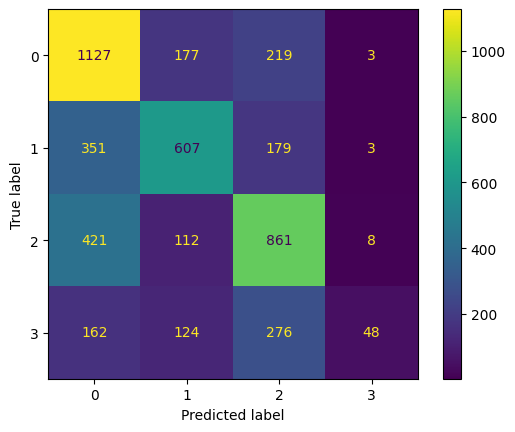

In [17]:
"""
- Con preprocesamiento mínimo
"""
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(dt_matrix_bin_train_min, y_train.ravel())
y_pred_bernoulli_min = bernoulli_nb.predict(dt_matrix_bin_dev_min)

ml_results["bernoulli_nb_min"] = get_metrics(y_dev, y_pred_bernoulli_min)

cm = confusion_matrix(y_dev, y_pred_bernoulli_min, labels=bernoulli_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=bernoulli_nb.classes_)
disp.plot()
plt.show()

save_model(bernoulli_nb, "bernoulli_nb_min")

In [18]:
"""
- Con preprocesamiento estándar
"""
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(dt_matrix_bin_train_std, y_train.ravel())
y_pred_bernoulli_std = bernoulli_nb.predict(dt_matrix_bin_dev_std)

ml_results["bernoulli_nb_std"] = get_metrics(y_dev, y_pred_bernoulli_std)

save_model(bernoulli_nb, "bernoulli_nb_std")

### Clasificador "Complement Naive Bayes"

In [19]:
"""
- Con preprocesamiento mínimo y pesado TF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tf_train_min, y_train.ravel())
y_pred_complementnb_tf_min = complement_nb.predict(dt_matrix_tf_dev_min)

ml_results["complement_nb_tf_min"] = get_metrics(y_dev, y_pred_complementnb_tf_min)

save_model(complement_nb, "complement_nb_tf_min")

In [20]:
"""
- Con preprocesamiento estándar y pesado TF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tf_train_std, y_train.ravel())
y_pred_complementnb_tf_std = complement_nb.predict(dt_matrix_tf_dev_std)

ml_results["complement_nb_tf_std"] = get_metrics(y_dev, y_pred_complementnb_tf_std)

save_model(complement_nb, "complement_nb_tf_std")

In [21]:
"""
- Con preprocesamiento mínimo y pesado TF-IDF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tfidf_train_min, y_train.ravel())
y_pred_complementnb_tfidf_min = complement_nb.predict(dt_matrix_tfidf_dev_min)

ml_results["complement_nb_tfidf_min"] = get_metrics(y_dev, y_pred_complementnb_tfidf_min)

save_model(complement_nb, "complement_nb_tfidf_min")

In [22]:
"""
- Con preprocesamiento estándar y pesado TF-IDF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tfidf_train_std, y_train.ravel())
y_pred_complementnb_tfidf_std = complement_nb.predict(dt_matrix_tfidf_dev_std)

ml_results["complement_nb_tfidf_std"] = get_metrics(y_dev, y_pred_complementnb_tfidf_std)

save_model(complement_nb, "complement_nb_tfidf_std")

### Clasificador "Support Vector Machine"

In [23]:
"""
- Con preprocesamiento mínimo y pesado binario
"""
svm = LinearSVC()
svm.fit(dt_matrix_bin_train_min, y_train.ravel())
y_pred_svm_bin_min = svm.predict(dt_matrix_bin_dev_min)

ml_results["svm_bin_min"] = get_metrics(y_dev, y_pred_svm_bin_min)

save_model(svm, "svm_bin_min")

In [24]:
"""
- Con preprocesamiento estándar y pesado binario
"""
svm = LinearSVC()
svm.fit(dt_matrix_bin_train_std, y_train.ravel())
y_pred_svm_bin_std = svm.predict(dt_matrix_bin_dev_std)

ml_results["svm_bin_std"] = get_metrics(y_dev, y_pred_svm_bin_std)

save_model(svm, "svm_bin_std")

In [25]:
"""
- Con preprocesamiento mínimo y pesado TF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tf_train_min, y_train.ravel())
y_pred_svm_tf_min = svm.predict(dt_matrix_tf_dev_min)

ml_results["svm_tf_min"] = get_metrics(y_dev, y_pred_svm_tf_min)

save_model(svm, "svm_tf_min")

/opt/anaconda3/envs/practica_pln1/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
"""
- Con preprocesamiento estándar y pesado TF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tf_train_std, y_train.ravel())
y_pred_svm_tf_std = svm.predict(dt_matrix_tf_dev_std)

ml_results["svm_tf_std"] = get_metrics(y_dev, y_pred_svm_tf_std)

save_model(svm, "svm_tf_std")

/opt/anaconda3/envs/practica_pln1/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
"""
- Con preprocesamiento mínimo y pesado TF-IDF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tfidf_train_min, y_train.ravel())
y_pred_svm_tfidf_min = svm.predict(dt_matrix_tfidf_dev_min)

ml_results["svm_tfidf_min"] = get_metrics(y_dev, y_pred_svm_tfidf_min)

save_model(svm, "svm_tfidf_min")

In [ ]:
"""
- Con preprocesamiento estándar y pesado TF-IDF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tfidf_train_std, y_train.ravel())
y_pred_svm_tfidf_std = svm.predict(dt_matrix_tfidf_dev_std)

ml_results["svm_tfidf_std"] = get_metrics(y_dev, y_pred_svm_tfidf_std)

save_model(svm, "svm_tfidf_std")

: 

## Clasificación con modelos de Aprendizaje Profundo 🧠

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
transformer_model = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

encoded_input = tokenizer(corpus_train_min,
                          padding=True,
                          truncation=True,
                          return_tensors="tf",
                          max_length=128)

outputs = transformer_model(encoded_input)
last_hidden_state = outputs.last_hidden_state
last_hidden_state

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
embedding_dim = 100
vocab_size = 200

model_dnn = Sequential()
model_dnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_dnn.add(Flatten())
model_dnn.add(Dense(128, activation="relu"))
model_dnn.add(Dense(64, activation="relu"))
model_dnn.add(Dense(32, activation="relu"))
model_dnn.add(Dense(4, activation="softmax"))

model_dnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_dnn.fit()

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_cnn.add(Flatten())
model_cnn.add(Conv1D(128, (5,), activation="relu"))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, (3,), activation="relu"))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation="relu"))
model_cnn.add(Dense(32, activation="relu"))
model_cnn.add(Dense(4, activation="softmax"))

model_cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

svm.fit(dt_matrix_tfidf_train_std, y_train.ravel())
y_pred_svm_tfidf_std = svm.predict(dt_matrix_tfidf_dev_std)

ml_results["svm_tfidf_std"] = get_metrics(y_dev, y_pred_svm_tfidf_std)

save_model(svm, "svm_tfidf_std")